<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None
   age           job  marital  education default  balance housing loan  \
0   58    management

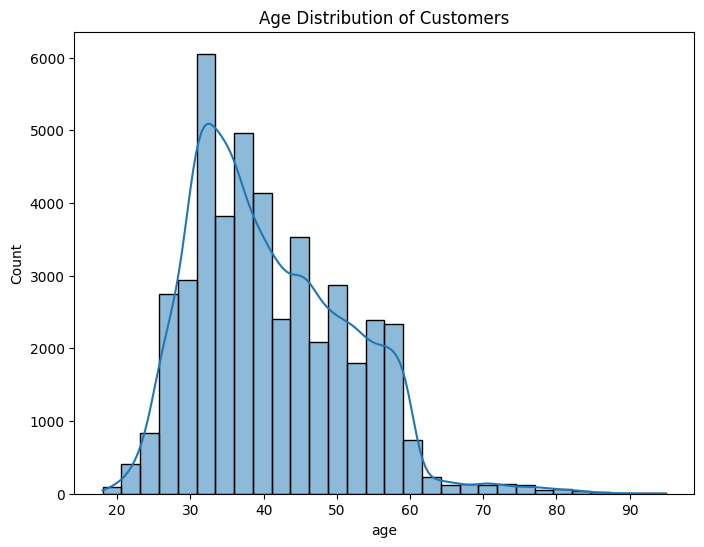

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# ----------------------------------------------
# 2. Load and Explore the Dataset
# ----------------------------------------------

# Updated path to your CSV file
file_path = '/Users/yousufhabib/Desktop/bank.csv'

# Load the CSV file using the correct delimiter
df = pd.read_csv(file_path, sep=';') 



# Print basic info about the DataFrame
print(df.info())  # This shows the data types and non-null counts

# Display the first few rows of the dataset
print(df.head())

# ----------------------------------------------
# 3. Clean and Preprocess
# ----------------------------------------------

df['age'] = df['age'].astype(int)

# Descriptive statistics
print(df.describe())

missing_values = df.isnull().sum()
print(missing_values)

duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

df['age'] = df['age'].astype(int)  # Example for converting 'age' to integer



# Plot age distribution
plt.figure(figsize=(8,6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution of Customers')
plt.show()


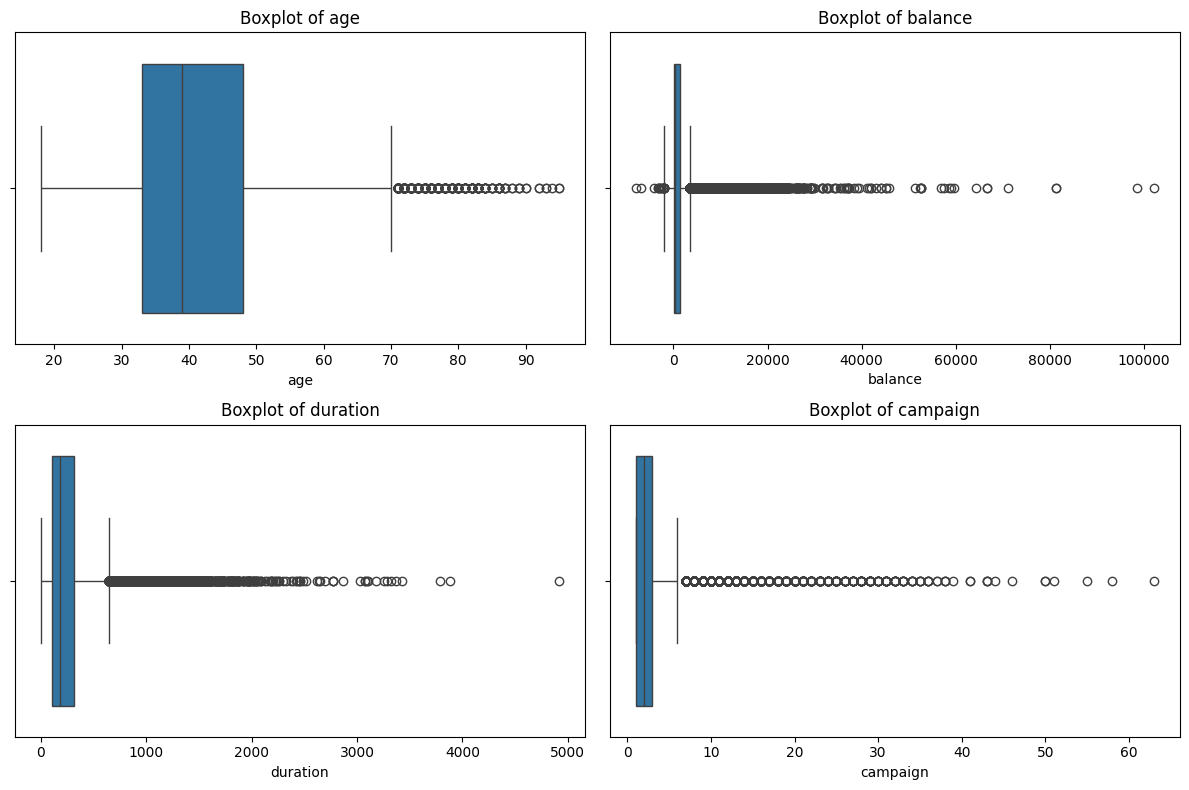

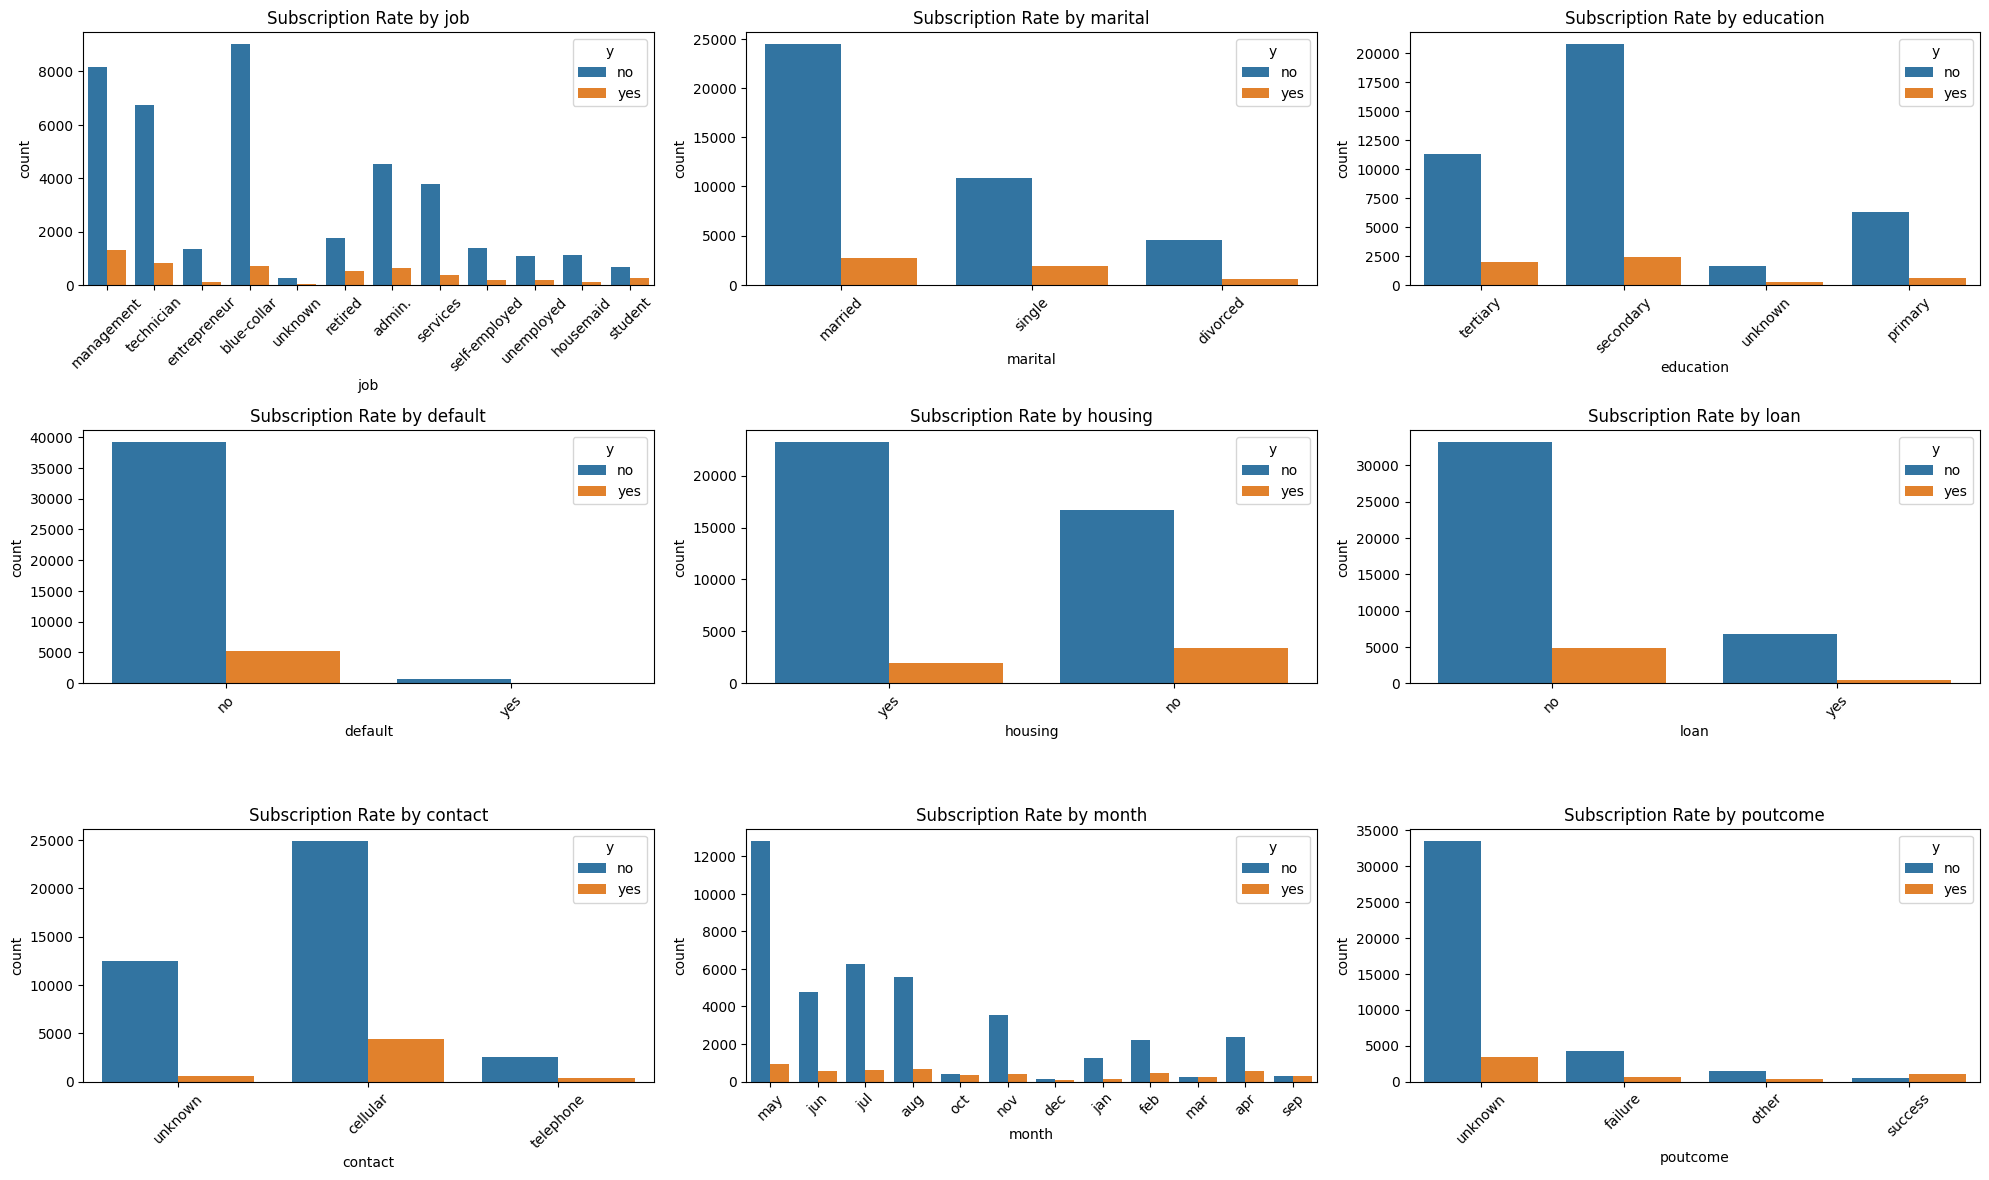

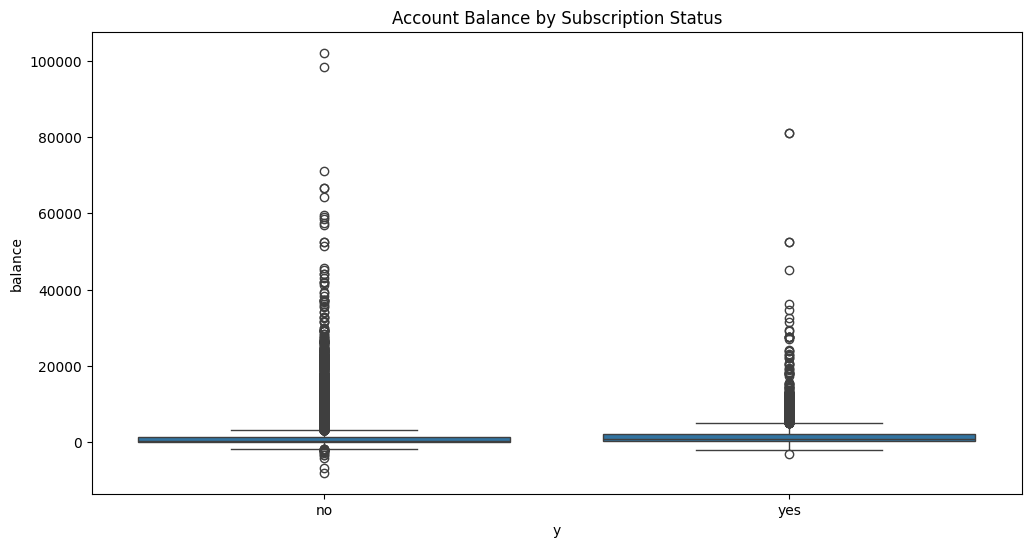

In [8]:
# Boxplot for numerical features
plt.figure(figsize=(12, 8))
for i, col in enumerate(['age', 'balance', 'duration', 'campaign'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Categorical feature countplots
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
plt.figure(figsize=(20, 15))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(4, 3, i)
    sns.countplot(data=df, x=column, hue='y')
    plt.xticks(rotation=45)
    plt.title(f'Subscription Rate by {column}')
plt.tight_layout()
plt.show()

# Boxplot: balance vs y
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='y', y='balance')
plt.title('Account Balance by Subscription Status')
plt.show()


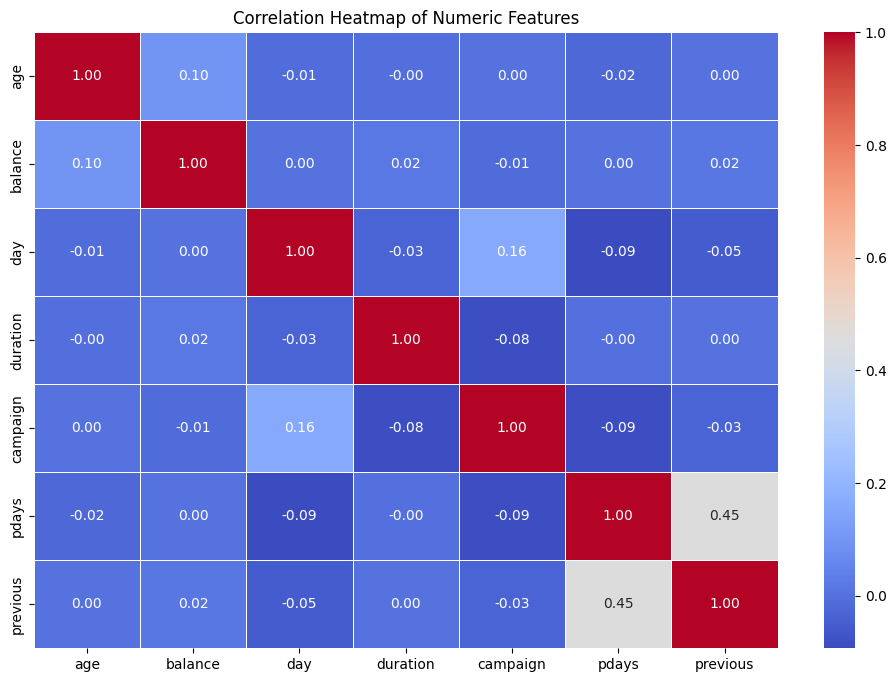

y                 no   yes  subscription_rate
balance_group                                
Negative/Zero   6778   502           6.895604
Low            20761  2539          10.896996
Medium          9979  1807          15.331750
High            2404   441          15.500879


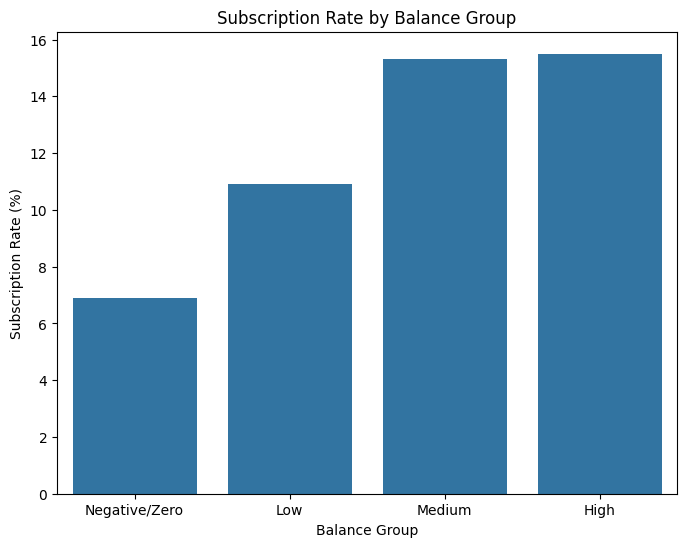

y                     no   yes  subscription_rate
duration_category                                
Short              10763   117           1.075368
Medium             20340  1714           7.771833
Long                6859  1625          19.153701
Very Long           1957  1833          48.364116


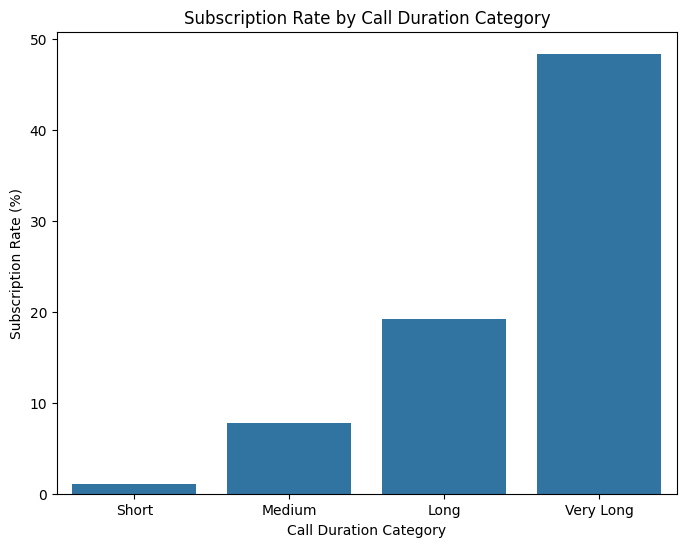

y                     no   yes  subscription_rate
campaign_category                                
1-2 calls          26087  3962          13.185131
3-5 calls           9733  1074           9.938003
6+ calls            4102   253           5.809414


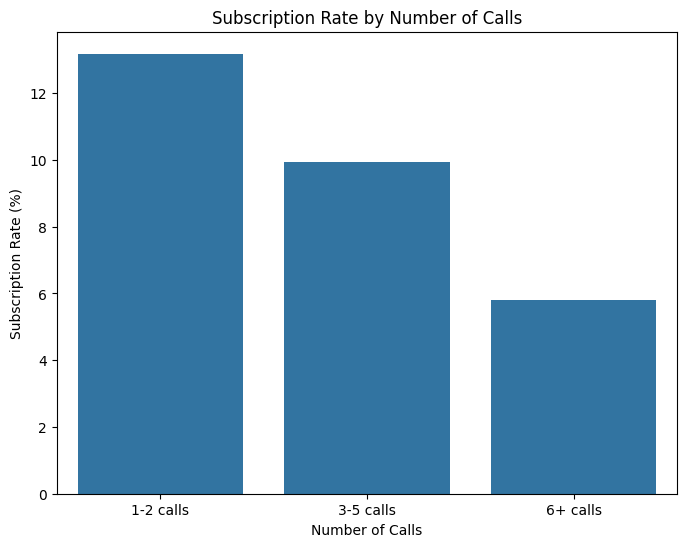

y                  no   yes  subscription_rate
pdays_category                                
Never Contacted     0     0                NaN
Recent            160    28          14.893617
Medium           2776  1339          32.539490
Long             3416   538          13.606474


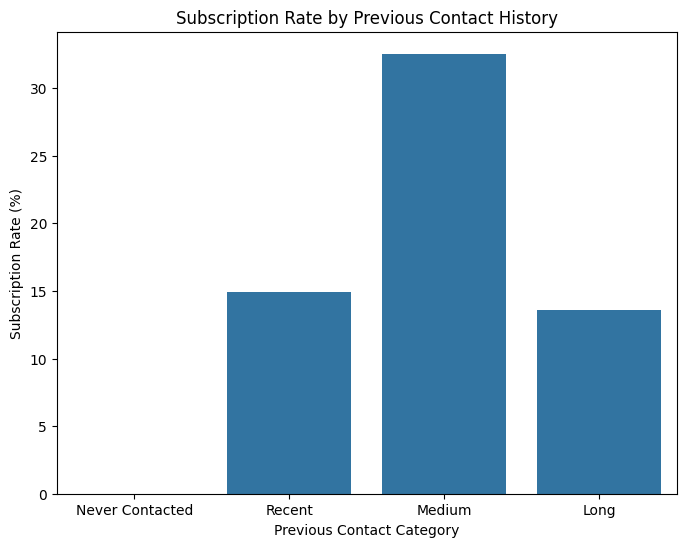

                        duration_campaign  balance_duration_ratio         y
duration_campaign                1.000000               -0.058331  0.207921
balance_duration_ratio          -0.058331                1.000000 -0.034535
y                                0.207921               -0.034535  1.000000


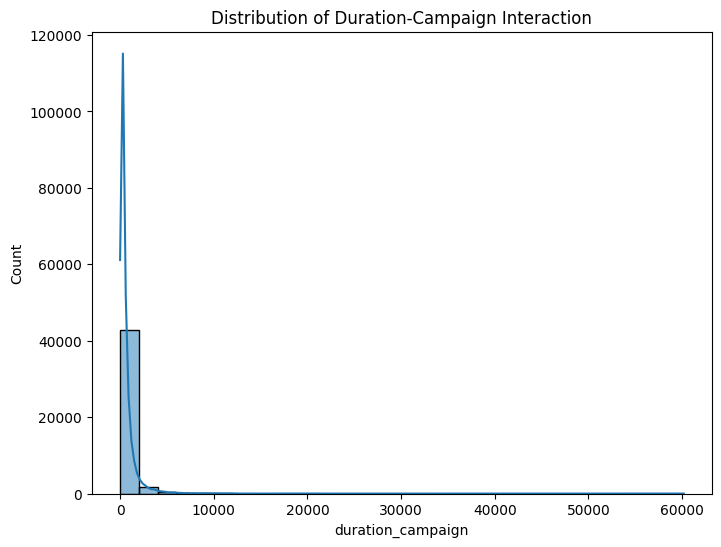

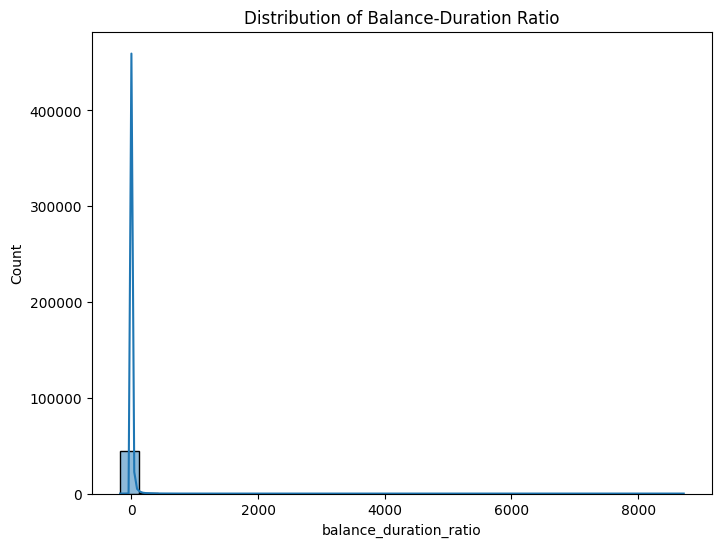

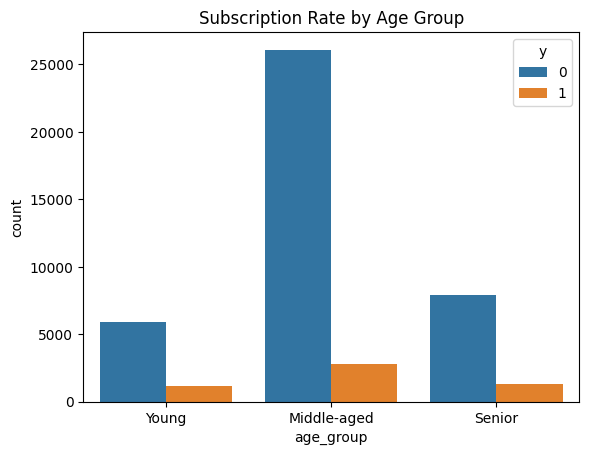

In [9]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# Balance analysis
balance_groups = pd.cut(df['balance'], bins=[-float('inf'), 0, 1000, 5000, float('inf')], 
                        labels=['Negative/Zero', 'Low', 'Medium', 'High'])
df['balance_group'] = balance_groups
balance_analysis = df.groupby(['balance_group', 'y'])['y'].count().unstack()
balance_analysis['subscription_rate'] = (balance_analysis['yes'] / 
                                         (balance_analysis['yes'] + balance_analysis['no'])) * 100
print(balance_analysis)
plt.figure(figsize=(8, 6))
sns.barplot(x='balance_group', y='subscription_rate', data=balance_analysis.reset_index())
plt.title('Subscription Rate by Balance Group')
plt.xlabel('Balance Group')
plt.ylabel('Subscription Rate (%)')
plt.show()

# Duration analysis
duration_bins = pd.cut(df['duration'], bins=[0, 100, 300, 600, float('inf')], 
                       labels=['Short', 'Medium', 'Long', 'Very Long'])
df['duration_category'] = duration_bins
duration_analysis = df.groupby(['duration_category', 'y'])['y'].count().unstack()
duration_analysis['subscription_rate'] = (duration_analysis['yes'] / 
                                          (duration_analysis['yes'] + duration_analysis['no'])) * 100
print(duration_analysis)
plt.figure(figsize=(8, 6))
sns.barplot(x='duration_category', y='subscription_rate', data=duration_analysis.reset_index())
plt.title('Subscription Rate by Call Duration Category')
plt.xlabel('Call Duration Category')
plt.ylabel('Subscription Rate (%)')
plt.show()

# Campaign analysis
campaign_bins = pd.cut(df['campaign'], bins=[0, 2, 5, float('inf')], 
                       labels=['1-2 calls', '3-5 calls', '6+ calls'])
df['campaign_category'] = campaign_bins
campaign_analysis = df.groupby(['campaign_category', 'y'])['y'].count().unstack()
campaign_analysis['subscription_rate'] = (campaign_analysis['yes'] / 
                                          (campaign_analysis['yes'] + campaign_analysis['no'])) * 100
print(campaign_analysis)
plt.figure(figsize=(8, 6))
sns.barplot(x='campaign_category', y='subscription_rate', data=campaign_analysis.reset_index())
plt.title('Subscription Rate by Number of Calls')
plt.xlabel('Number of Calls')
plt.ylabel('Subscription Rate (%)')
plt.show()

# Pdays analysis
pdays_bins = pd.cut(df['pdays'], bins=[-1, 0, 30, 200, float('inf')], 
                    labels=['Never Contacted', 'Recent', 'Medium', 'Long'])
df['pdays_category'] = pdays_bins
pdays_analysis = df.groupby(['pdays_category', 'y'])['y'].count().unstack()
pdays_analysis['subscription_rate'] = (pdays_analysis['yes'] / 
                                       (pdays_analysis['yes'] + pdays_analysis['no'])) * 100
print(pdays_analysis)
plt.figure(figsize=(8, 6))
sns.barplot(x='pdays_category', y='subscription_rate', data=pdays_analysis.reset_index())
plt.title('Subscription Rate by Previous Contact History')
plt.xlabel('Previous Contact Category')
plt.ylabel('Subscription Rate (%)')
plt.show()

# Feature engineering
df_scaled = df.copy()
df_scaled['duration_campaign'] = df_scaled['duration'] * df_scaled['campaign']
df_scaled['age_group'] = pd.cut(df_scaled['age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle-aged', 'Senior'])
df_scaled['balance_duration_ratio'] = df_scaled['balance'] / (df_scaled['duration'] + 1)
df_scaled['y'] = df['y'].map({'no': 0, 'yes': 1})

# Correlation for engineered features
print(df_scaled[['duration_campaign', 'balance_duration_ratio', 'y']].corr())
plt.figure(figsize=(8, 6))
sns.histplot(df_scaled['duration_campaign'], kde=True, bins=30)
plt.title('Distribution of Duration-Campaign Interaction')
plt.show()
plt.figure(figsize=(8, 6))
sns.histplot(df_scaled['balance_duration_ratio'], kde=True, bins=30)
plt.title('Distribution of Balance-Duration Ratio')
plt.show()
sns.countplot(x='age_group', hue='y', data=df_scaled)
plt.title('Subscription Rate by Age Group')
plt.show()

In [10]:
# VIF calculation
numeric_columns = df_scaled.select_dtypes(include=['float64', 'int64']).columns
vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_columns
vif_data['VIF'] = [variance_inflation_factor(df_scaled[numeric_columns].values, i) for i in range(len(numeric_columns))]
print(vif_data)

# Preprocessing and modeling
df_encoded = pd.get_dummies(df, drop_first=True)
scaler = StandardScaler()
numeric_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])
y = df_encoded['y_yes']
X = df_encoded.drop(columns=['y_yes'])

                  Feature       VIF
0                     age  5.227402
1                 balance  1.448755
2                     day  4.002878
3                duration  3.961591
4                campaign  2.626223
5                   pdays  1.462795
6                previous  1.345763
7                       y  1.366996
8       duration_campaign  3.030974
9  balance_duration_ratio  1.248738


Normal Logistic Regression Accuracy: 0.9001437576025655

Classification Report:
               precision    recall  f1-score   support

       False       0.92      0.97      0.94      7952
        True       0.65      0.38      0.48      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.67      0.71      9043
weighted avg       0.89      0.90      0.89      9043



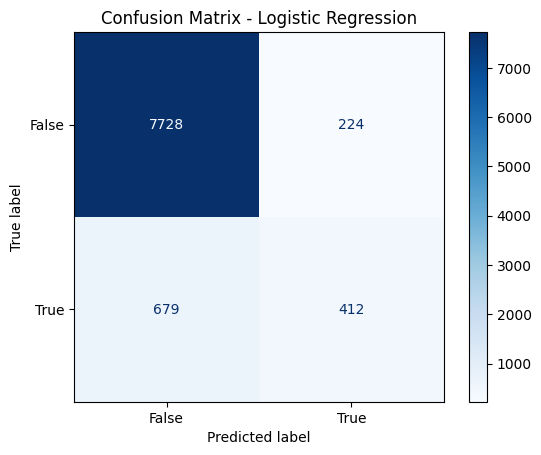


ROC-AUC Score: 0.9060294396996091


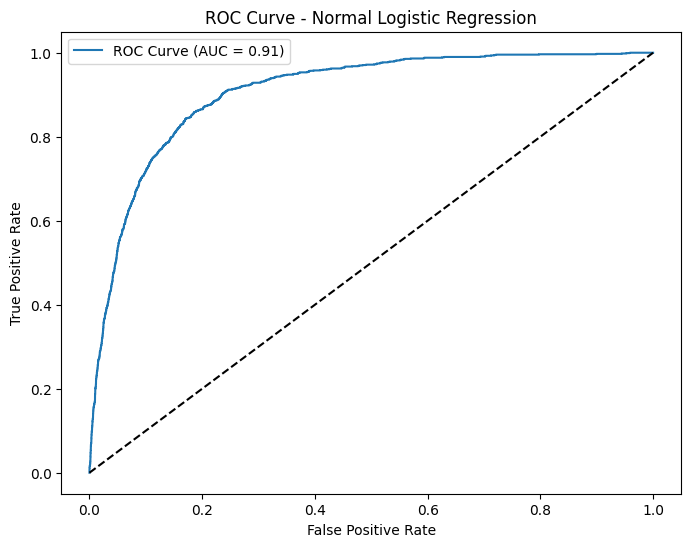


Normal Random Forest Accuracy: 0.9022448302554462

Classification Report:
               precision    recall  f1-score   support

       False       0.92      0.97      0.95      7952
        True       0.65      0.41      0.51      1091

    accuracy                           0.90      9043
   macro avg       0.79      0.69      0.73      9043
weighted avg       0.89      0.90      0.89      9043



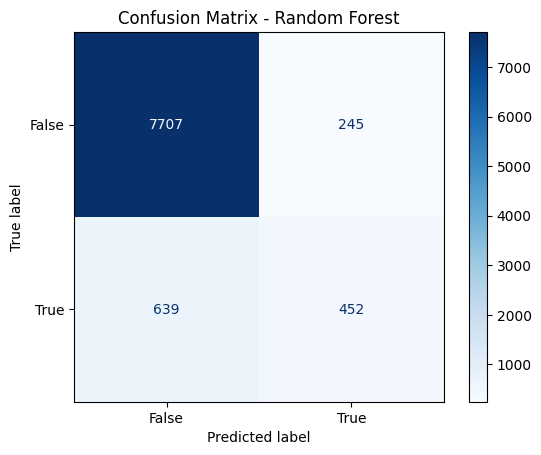


ROC-AUC Score: 0.9264001170174115


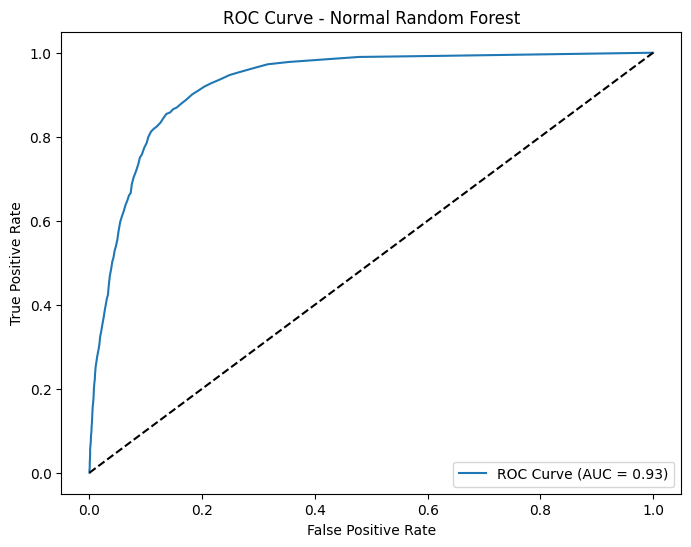

In [11]:
# Save original split for non-tuned models
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42)

# Normal Logistic Regression
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=1000, random_state=42))
])
logistic_pipeline.fit(X_train_orig, y_train_orig)
y_pred_orig = logistic_pipeline.predict(X_test_orig)
y_prob_orig = logistic_pipeline.predict_proba(X_test_orig)[:, 1]
print("Normal Logistic Regression Accuracy:", accuracy_score(y_test_orig, y_pred_orig))
print("\nClassification Report:\n", classification_report(y_test_orig, y_pred_orig))
ConfusionMatrixDisplay.from_predictions(y_test_orig, y_pred_orig, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()
roc_auc_orig = roc_auc_score(y_test_orig, y_prob_orig)
print("\nROC-AUC Score:", roc_auc_orig)
fpr, tpr, _ = roc_curve(y_test_orig, y_prob_orig)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_orig:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Normal Logistic Regression')
plt.legend()
plt.show()

# Normal Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_orig, y_train_orig)
y_pred_rf = rf_model.predict(X_test_orig)
y_pred_proba_rf = rf_model.predict_proba(X_test_orig)[:, 1]
print("\nNormal Random Forest Accuracy:", accuracy_score(y_test_orig, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test_orig, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test_orig, y_pred_rf, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()
roc_auc_rf = roc_auc_score(y_test_orig, y_pred_proba_rf)
print("\nROC-AUC Score:", roc_auc_rf)
fpr, tpr, _ = roc_curve(y_test_orig, y_pred_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Normal Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Best Logistic Params: {'logistic__C': 10, 'logistic__penalty': 'l2', 'logistic__solver': 'liblinear'}
Best ROC-AUC Score (CV): 0.9456563129364653

Tuned Logistic Regression Report:
               precision    recall  f1-score   support

       False       0.88      0.88      0.88      7908
        True       0.88      0.88      0.88      8061

    accuracy                           0.88     15969
   macro avg       0.88      0.88      0.88     15969
weighted avg       0.88      0.88      0.88     15969



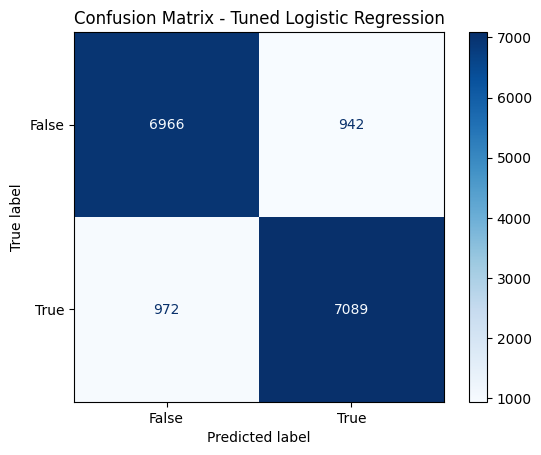

ROC-AUC Score: 0.9461358657685828


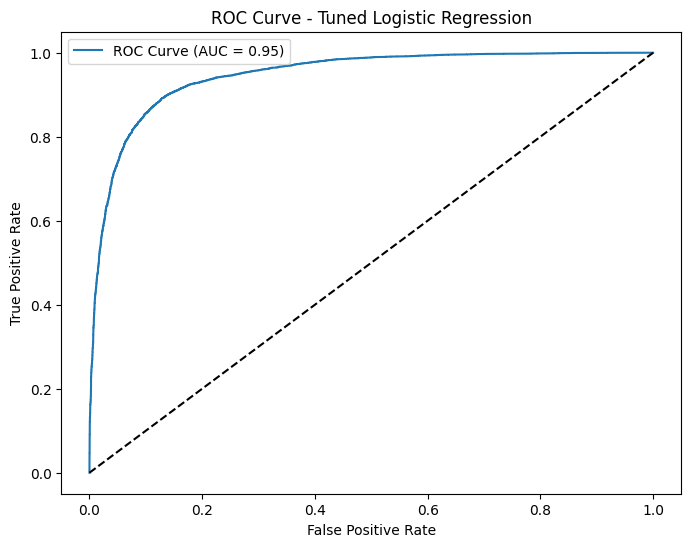


Tuned Random Forest Accuracy: 0.8834617070574238

Classification Report:
               precision    recall  f1-score   support

       False       0.90      0.86      0.88      7908
        True       0.87      0.90      0.89      8061

    accuracy                           0.88     15969
   macro avg       0.88      0.88      0.88     15969
weighted avg       0.88      0.88      0.88     15969



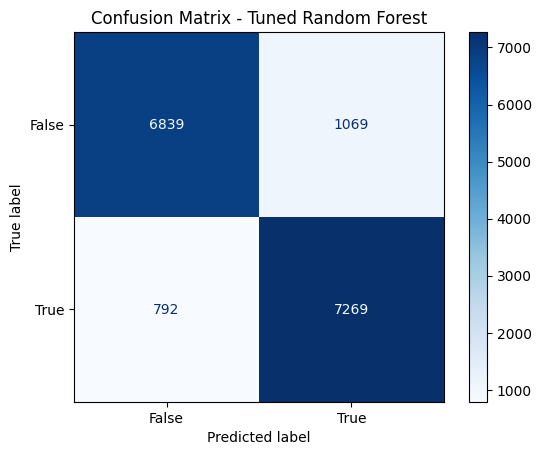


ROC-AUC Score: 0.9516229923489938


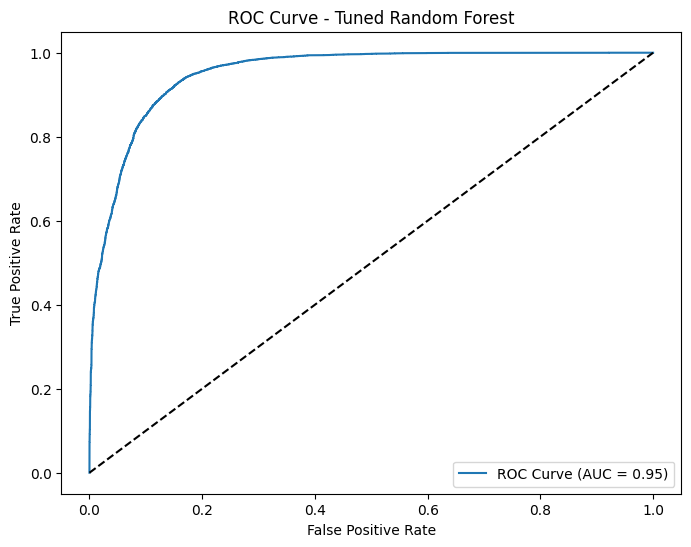

In [12]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Hyperparameter Tuning - Logistic Regression
tuned_logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=1000, random_state=42))
])
param_grid = {
    'logistic__C': [0.01, 0.1, 1, 10],
    'logistic__penalty': ['l1', 'l2'],
    'logistic__solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(tuned_logistic_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Logistic Params:", grid_search.best_params_)
print("Best ROC-AUC Score (CV):", grid_search.best_score_)
best_logistic = grid_search.best_estimator_
y_pred = best_logistic.predict(X_test)
y_prob = best_logistic.predict_proba(X_test)[:, 1]
print("\nTuned Logistic Regression Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.show()
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned Logistic Regression")
plt.legend()
plt.show()

# Tuned Random Forest
tuned_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
tuned_rf.fit(X_train, y_train)
y_pred_rf_tuned = tuned_rf.predict(X_test)
y_pred_proba_rf_tuned = tuned_rf.predict_proba(X_test)[:, 1]
print("\nTuned Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf_tuned))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_tuned, cmap='Blues')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.show()
roc_auc_rf_tuned = roc_auc_score(y_test, y_pred_proba_rf_tuned)
print("\nROC-AUC Score:", roc_auc_rf_tuned)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf_tuned)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_rf_tuned:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Tuned Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

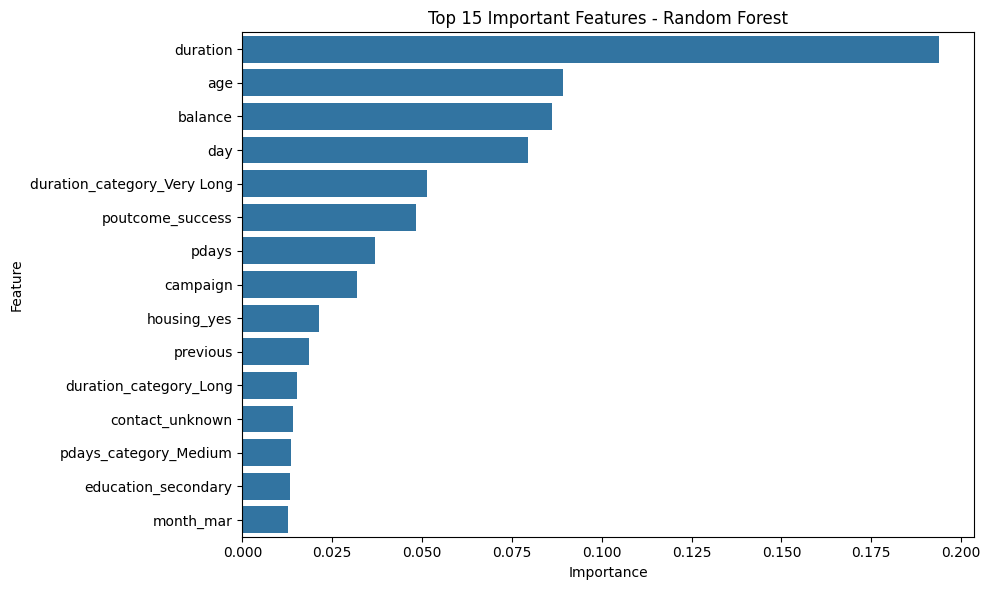

In [13]:
# Feature importance
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df[:15])
plt.title('Top 15 Important Features - Random Forest')
plt.tight_layout()
plt.show()

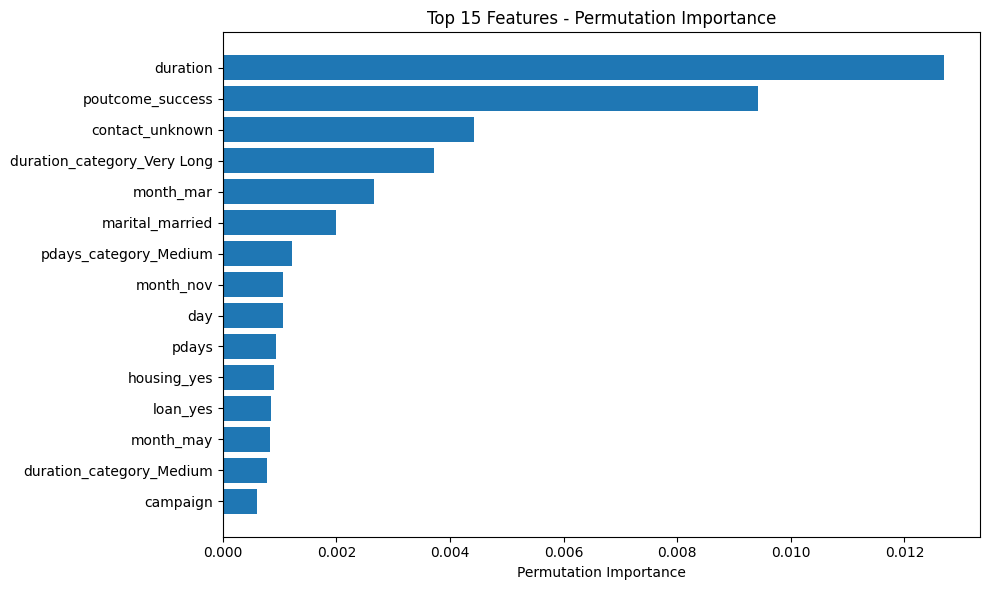

In [16]:
# Permutation importance
perm = permutation_importance(rf_model, X_test_orig, y_test_orig, n_repeats=10, random_state=42)
sorted_idx = np.argsort(perm.importances_mean)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(range(15), perm.importances_mean[sorted_idx[:15]])
plt.yticks(range(15), X_test_orig.columns[sorted_idx[:15]])
plt.xlabel("Permutation Importance")
plt.title("Top 15 Features - Permutation Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()